## Relax Challenge
---
In this notebook, we will explore the two datasets to identify the contributing factors for prediciting future user adoption. An 'Adopted User' is defined as a user who has logged into the product on three separate days in atleast one seven-day period. 

Let's take a look at the data,
1. **User Tabel(takehome_users)**: Data on 12,000 users who signed up for the product in the last two years
This table includes:    
    a). name: the user's name   
    b). object_id: the user's id   
    c). email: email address   
    d). creation_source: how their account was created. This takes on one of 5 values:   
        i.  PERSONAL_PROJECTS: invited to join another user's personal workspace
        ii. GUEST_INVITE: invited to an organization as a guest (limited permissions)
        iii.ORG_INVITE: invited to an organization (as a full member)
        iv  SIGNUP: signed up via the website
        v   SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login
        id)
    e) creation_time: when they created their account   
    f) last_session_creation_time: unix timestamp of last login   
    g) opted_in_to_mailing_list: whether they have opted into receiving marketing emails  
    h) enabled_for_marketing_drip: whether they are on the regular marketing email drip   
    i) org_id: the organization (group of users) they belong to invited_by_user_id: which user invited them to join (if applicable).
    
    
2. usage summary table ("takehome_user_engagement"): Has a row for each day that a user logged into the product.


In [1]:
### Importing required libraries
import pandas as pd
import datetime  
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

In [2]:
## Loading takehome_users data
users = pd.read_csv("takehome_users.csv",encoding="ISO-8859-1")

print(users.info())
print(117*'-')
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB
None
---------------------------------------------------------------------------------------------------------------------


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


> Quick glance at the data, we see that they are two different data types (Numerical and categorical). We also notice the data contains NULL values in last_session_creation_time and invited_by_user_id column. Also, note that creation time is read as float as the column has timestamp in Unix format. We will deal with this further in the notebook.

In [3]:
# load and user enagagement data
user_engage = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])
print(user_engage.info())
user_engage.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB
None


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


> In the user enagagement data we do not see any missing values. By Joining users engagement and users data, we will have information of user login per day along with user features. Before that lets see if all the users who signed up were active. This information can be extracted by comparing number of unique users in both the datasets. We will define an 'atleastonce' user as a user who was active atleast once after signing up.

In [4]:
## users signed up vs users active

signup_users = len(users.object_id.unique())
atleastonce_users = len(user_engage.user_id.unique())

print("Number of users who signed up:", signup_users)
print("Number of users who were active:", atleastonce_users)

print("Number of users who were did not have a single activity after signup:", signup_users-atleastonce_users)
print(100*'-')
print("Percentage of users who never logged in after sign up:",(signup_users-atleastonce_users)*100/signup_users,"%")

Number of users who signed up: 12000
Number of users who were active: 8823
Number of users who were did not have a single activity after signup: 3177
----------------------------------------------------------------------------------------------------
Percentage of users who never logged in after sign up: 26.475 %


> From the above, we see a quater of users signed in but never used the application. They might be many reasons for this, people signed in o request from friends, some referal programs, some offers. Here we cannot deduct/pinpoint a reason as we do not have anay data to back. Before moving on to next step i.e., finding "Adopted Users". We see how the 3177 users who never had an activity signed up

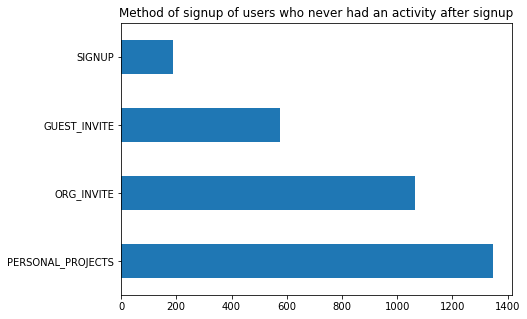

In [5]:
## MEthod of signup of users 
users[~users['object_id'].isin(list(user_engage.user_id.unique()))].creation_source.value_counts().plot(kind='barh')
plt.title("Method of signup of users who never had an activity after signup")
plt.gcf().set_size_inches(7,5)
plt.show()

> The plot is interesting as the users who never had activity seem to join by "personal_project" method i.e., they are asked to join someone's workspace. Let's see this as comapared to the users who have activity

In [6]:
## People who are active
print("users with atleast one login/activity")
print(100*'-')
print(users[users['object_id'].isin(list(user_engage.user_id.unique()))].
      creation_source.value_counts(normalize=True)*100)
print('')
print("users without one login/activity")
print(100*'-')
print(users[~users['object_id'].isin(list(user_engage.user_id.unique()))].
      creation_source.value_counts(normalize=True)*100)

users with atleast one login/activity
----------------------------------------------------------------------------------------------------
ORG_INVITE            36.132835
SIGNUP                21.511957
GUEST_INVITE          17.998413
SIGNUP_GOOGLE_AUTH    15.697609
PERSONAL_PROJECTS      8.659186
Name: creation_source, dtype: float64

users without one login/activity
----------------------------------------------------------------------------------------------------
PERSONAL_PROJECTS    42.398489
ORG_INVITE           33.553667
GUEST_INVITE         18.098835
SIGNUP                5.949008
Name: creation_source, dtype: float64


> The above ouput clearly shows the difference between users without a single login and users with atleast one login. Now we move on to identifiying the "Adopted User" : A user who has logged into the product on three separate days in atleast one seven-day period. We already have 3177 of no-active users who would be classified as Adopted Users. Now e have to look in the user_enage data to see if we have additional Adopted Users

In [7]:
## Finding adopted users

## Create a dictionary to save the adopted users data
adopt = {x:False for x in range(1, len(users)+1)}

"""
Here in the code below, we will loop over the user_engage data set,
1. We will filter the people with less than three login as these users would not staisfy the 
criteria of Adopted User
2. After filtering, we will take each time stamp see if we have two other timestamps in the 7day window.
"""
for user in user_engage.groupby('user_id'):
    #print(user) /*Just checking if the loop is correct*/
    
    # Getting time stamps
    time_stamps = user[1]['time_stamp'].sort_values().reset_index(drop=True)
    
    user_id,total_logins = user[0],len(time_stamps) # Getting the user_id and number of logins per userID
    
    #Filtering the users with less than total_logins less than 3
    if total_logins < 3:
        continue
     
    #Window of 7days given a time stamp
    for i, time in enumerate(time_stamps):
        if i == total_logins-2:
            break  
        start = time
        end = start + pd.Timedelta('7D')
        next_time_1 = time_stamps[i+1]
        next_time_2 = time_stamps[i+2]
        if (next_time_1 < end) & (next_time_2 < end):
            adopt[user_id] = True
            break    
            
print('Percentage of Adopted User in the data: ',sum(adopt.values())*100/len(users),'%')


Percentage of Adopted User in the data:  13.35 %


> We see that 13.35% of the users are adopted. Let's join the two dataseta and see if we can plot any interestign features

In [8]:
## to dataframe from dictionary
adopt_data = pd.DataFrame.from_dict(adopt,orient='index').reset_index()
adopt_data.columns = ['user_id','Adopted_user']
adopt_data.head()

,user_id,Adopted_user
0,1,False
1,2,True
2,3,False
3,4,False
4,5,False


In [9]:
#Joining the two dataframe
users['user_id'] = users.object_id
users_join = pd.merge(users, adopt_data, on='user_id', how='outer')

In [10]:
users_join.pop('object_id')
users_join.head(10)

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,Adopted_user
0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1,False
1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2,True
2,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,3,False
3,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,4,False
4,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,5,False
5,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,6,False
6,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,7,False
7,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,8,False
8,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,9,False
9,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,10,True


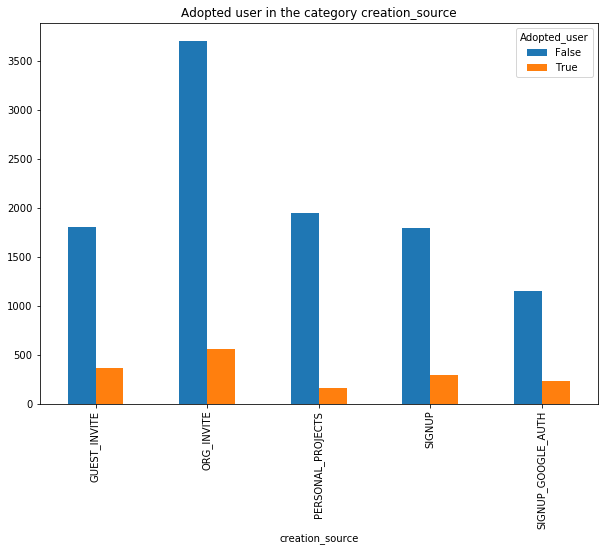

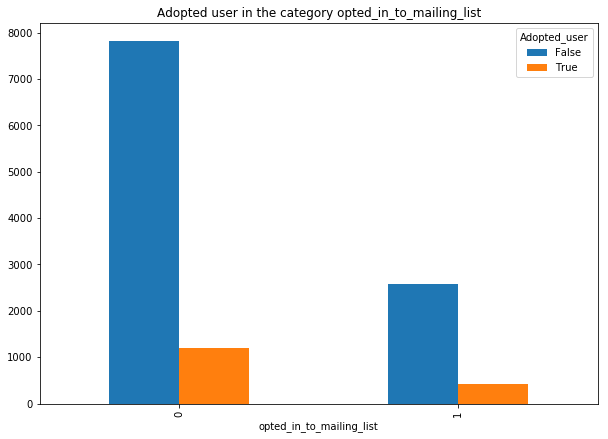

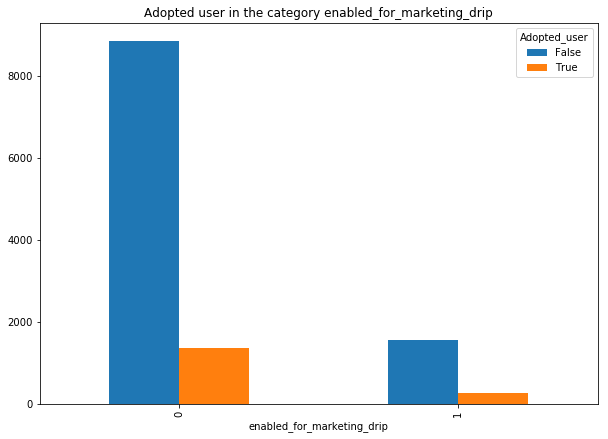

In [11]:
## ADopted users creation source
for col in ['creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip']:
    users_join.groupby([col,'Adopted_user'])[col].count().\
    sort_values(ascending=True).unstack().plot(kind='bar', figsize =(10,7))
    plt.title("Adopted user in the category " + col)
    plt.show()
    print('')

The above plots show adopted user distribution in each of the categories. However, we dont see noticebale difference. We train a RandomForest classifier to get the important features 

In [12]:
## COnveriting unix to time
users_join.creation_time = pd.to_datetime(users_join.creation_time)
users_join.last_session_creation_time = pd.to_datetime(users_join.last_session_creation_time, unit='s')

users_join.rename(columns={'last_session_creation_time': 'last_session', 'creation_time': 'creation'}, inplace=True)
for col in ['last_session','creation']:
    users_join["month_"+col] = users_join[col].dt.month
    users_join["day_"+col] = users_join[col].dt.day

In [13]:
## Drop the columns we do not need anylonger and ones without any predictive capabilities
users_join.drop(['creation','name','email','last_session','invited_by_user_id','user_id'],axis=1,inplace=True)
users_join.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,Adopted_user,month_last_session,day_last_session,month_creation,day_creation
0,GUEST_INVITE,1,0,11,False,4.0,22.0,4,22
1,ORG_INVITE,0,0,1,True,3.0,31.0,11,15
2,ORG_INVITE,0,0,94,False,3.0,19.0,3,19
3,GUEST_INVITE,0,0,1,False,5.0,22.0,5,21
4,GUEST_INVITE,0,0,193,False,1.0,22.0,1,17


In [14]:
## One hot encoding creation source column
users_join.rename(columns={'creation_source':'source'},inplace=True)
final = pd.get_dummies(users_join, columns = ['source'], drop_first=True)


In [15]:
## Filling our data 
final.fillna(0,axis=1,inplace=True)
final.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,Adopted_user,month_last_session,day_last_session,month_creation,day_creation,source_ORG_INVITE,source_PERSONAL_PROJECTS,source_SIGNUP,source_SIGNUP_GOOGLE_AUTH
0,1,0,11,False,4.0,22.0,4,22,0,0,0,0
1,0,0,1,True,3.0,31.0,11,15,1,0,0,0
2,0,0,94,False,3.0,19.0,3,19,1,0,0,0
3,0,0,1,False,5.0,22.0,5,21,0,0,0,0
4,0,0,193,False,1.0,22.0,1,17,0,0,0,0


In [16]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Scikit Learn Machine Learning libraries
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score

In [17]:
X = final.drop('Adopted_user', axis=1)
target = final['Adopted_user']

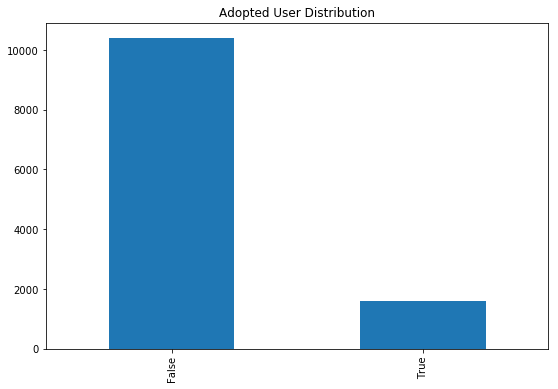

Percenatge distribution of target/dependent variable: 
 False    86.65
True     13.35
Name: Adopted_user, dtype: float64


In [18]:
target.value_counts().plot(kind='bar')
plt.title("Adopted User Distribution")
plt.gcf().set_size_inches(9,6)
plt.show()

print("Percenatge distribution of target/dependent variable: \n",
      users_join.Adopted_user.value_counts(normalize=True)*100 )



In [19]:
#Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size = 0.2, random_state=123, stratify=target)

In [20]:
print("After stratification distribution of traget variables in train and test data \n"+ 100*'-' 
      + '\n' + "Training data")
print(y_train.value_counts(normalize=True)*100)
print('')
print("Test Data")
y_test.value_counts(normalize=True)*100

After stratification distribution of traget variables in train and test data 
----------------------------------------------------------------------------------------------------
Training data
False    86.645833
True     13.354167
Name: Adopted_user, dtype: float64

Test Data


False    86.666667
True     13.333333
Name: Adopted_user, dtype: float64

In [21]:
## Cross Validation
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

## Metric for model evaluation: Area Under the Receiver Operating Characteristic curve. 
model_metric  = make_scorer(roc_auc_score, greater_is_better=True)

In [22]:
#Initilizing Random Forest Classifier
RF = RandomForestClassifier(criterion='gini',n_jobs=-1)

## Defining Hyperparamter grid and gridsearch
param_grid = {'n_estimators' : [40, 50, 60], 'min_samples_split' : [2, 3, 4], 
              'max_depth' : [4, 7, 10], 'class_weight' : [None,'balanced',{0:1,1:2},{0:1,1:3}]}

RF_CV = GridSearchCV(RF, param_grid, cv=CV, scoring=model_metric, verbose=1)

In [23]:
## Fitting the data to RF classifier
RF_CV.fit(X_train, y_train)

#Print out the best model
print("Best parameters learned: ",RF_CV.best_params_)
print("AUROC score with best RF paramters",RF_CV.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  4.4min finished


Best parameters learned:  {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 60, 'min_samples_split': 4}
AUROC score with best RF paramters 0.916618072725


In [24]:
### Initialzing RandomForest Classifier with best parameters learned from Gridsearch

RF_best_param = RandomForestClassifier(criterion='gini', class_weight= RF_CV.best_params_['class_weight'], n_jobs=-1, 
                                       min_samples_split=RF_CV.best_params_['min_samples_split'], 
                                       max_depth=RF_CV.best_params_['max_depth'],
                                      n_estimators=RF_CV.best_params_['n_estimators'],)

## Fitting the model
RF_best_param.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            n_estimators=60, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [25]:
## Plotting AUROC scores to evaluate the model

## Code extracted from scikit learn: 
## http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

import numpy as np
from sklearn.model_selection import learning_curve



def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

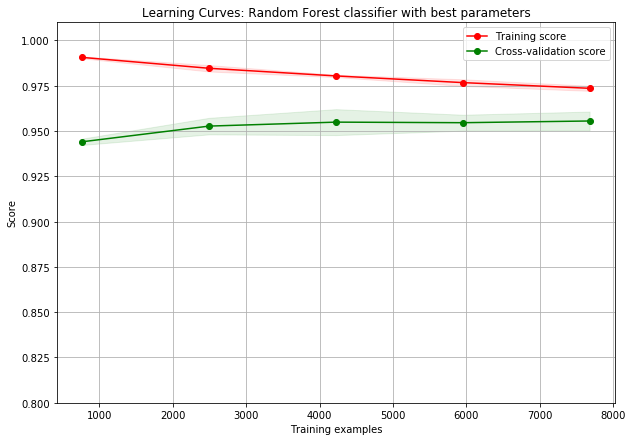

In [26]:
X, y = X_train, y_train


title = "Learning Curves: Random Forest classifier with best parameters"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.

plot_learning_curve(RF_best_param, title, X, y, ylim=(0.8, 1.01), cv=CV, n_jobs=-1)
plt.gcf().set_size_inches(10,7)

plt.show()

In [27]:
## Prediction TEST SET

from sklearn.model_selection import cross_val_score
y_pred_prob = RF_best_param.predict_proba(X_test)[:,1]
print("AUROC score", roc_auc_score(y_test, y_pred_prob))
cv_auc = cross_val_score(RF_best_param, X, y, cv = CV,scoring = model_metric)
print("AUCROC score using 5-fold CV:  ",format(cv_auc))


AUROC score 0.984508713942
AUCROC score using 5-fold CV:   [ 0.91000192  0.93243158  0.90414663  0.90954318  0.9244224 ]


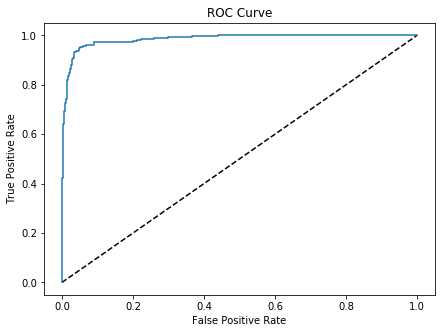

In [28]:
## Plotting ROC CURVE
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = RF_best_param.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plotting ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.gcf().set_size_inches(7,5)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [29]:
## Getting feature importance from classifier## Getti 
feature_importances = pd.DataFrame(RF_best_param.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(11)

,importance
month_last_session,0.417080
day_last_session,0.265063
month_creation,0.154668
day_creation,0.081354
org_id,0.052489
source_PERSONAL_PROJECTS,0.006881
source_SIGNUP_GOOGLE_AUTH,0.004832
source_SIGNUP,0.004679
enabled_for_marketing_drip,0.004488
opted_in_to_mailing_list,0.004364


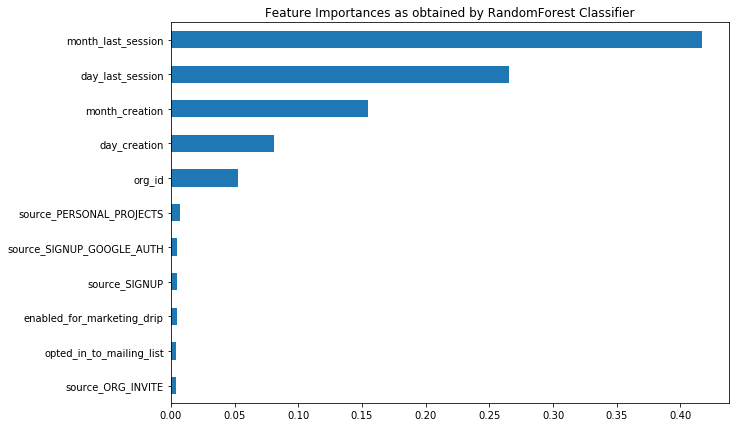

In [30]:
feature_importances.sort_values('importance', ascending=True).plot(kind = 'barh',legend=False)
plt.title("Feature Importances as obtained by RandomForest Classifier")
plt.gcf().set_size_inches(10,7)

>Feature importance plot shows that month and day the user was last active, and organization id(the organization (group of users) they belong to invited_by_user_id: which user invited them to join (if applicable) are important in prediciting. While we can point that how can signing in a particular month makes the user adopted. At this point, this is not clear unless we have other data associated with the particulars of the month, are they any offers that month which can make users be active etc. Organization Id also came out as an important feature, this is a potential source to investigate which are all the organizations have high percentage of adopted users. However, we need more features pertaining to user, organisation work, types of projects, offers provided for signup etc   
Finally, this notebook is far from real world however it shows the data science workflow and typical approach in answering and posing a question.